# Computer Vision

## Lab 2


### Imports


In [2]:
# Computation
import cv2
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Typing
import typing as types

### Section 1


#### Gaussian


array([[2.37941181e-13, 6.21430143e-13, 1.55934869e-12, ...,
        3.75943329e-12, 1.55934869e-12, 6.21430143e-13],
       [6.21430143e-13, 1.62298691e-12, 4.07254546e-12, ...,
        9.81849866e-12, 4.07254546e-12, 1.62298691e-12],
       [1.55934869e-12, 4.07254546e-12, 1.02191992e-11, ...,
        2.46374643e-11, 1.02191992e-11, 4.07254546e-12],
       ...,
       [3.75943329e-12, 9.81849866e-12, 2.46374643e-11, ...,
        5.93984555e-11, 2.46374643e-11, 9.81849866e-12],
       [1.55934869e-12, 4.07254546e-12, 1.02191992e-11, ...,
        2.46374643e-11, 1.02191992e-11, 4.07254546e-12],
       [6.21430143e-13, 1.62298691e-12, 4.07254546e-12, ...,
        9.81849866e-12, 4.07254546e-12, 1.62298691e-12]])

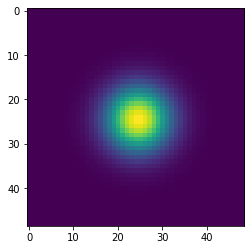

In [3]:
def make_Gaussian(sigma: int, shape: tuple[int, int]):
    var = sigma ** 2

    def Gaussian(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        return (1/(2 * np.pi * var)) * np.exp(-((centred_x ** 2 + centred_y ** 2) / (2 * var)))

    return np.fromfunction(Gaussian, shape=shape)

kernel_shape = (49, 49)

gaussian = make_Gaussian(sigma=5, shape=kernel_shape)
plt.imshow(gaussian)
gaussian

#### Laplacian of Gaussian (LoG)

array([[2.79810854e-30, 3.86354990e-29, 4.77390899e-28, ...,
        5.27913636e-27, 4.77390899e-28, 3.86354990e-29],
       [3.86354990e-29, 5.32513197e-28, 6.56759562e-27, ...,
        7.24853695e-26, 6.56759562e-27, 5.32513197e-28],
       [4.77390899e-28, 6.56759562e-27, 8.08412060e-26, ...,
        8.90407585e-25, 8.08412060e-26, 6.56759562e-27],
       ...,
       [5.27913636e-27, 7.24853695e-26, 8.90407585e-25, ...,
        9.78618163e-24, 8.90407585e-25, 7.24853695e-26],
       [4.77390899e-28, 6.56759562e-27, 8.08412060e-26, ...,
        8.90407585e-25, 8.08412060e-26, 6.56759562e-27],
       [3.86354990e-29, 5.32513197e-28, 6.56759562e-27, ...,
        7.24853695e-26, 6.56759562e-27, 5.32513197e-28]])

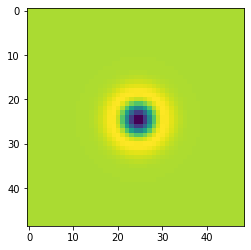

In [4]:
def make_LoG(sigma: int, shape: tuple[int, int]):
    var = sigma ** 2

    def log(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        exponent = -((centred_x ** 2 + centred_y ** 2) / (2 * var))
        return -(1/(np.pi * (var ** 2))) * (1 + exponent) * np.exp(exponent)

    return np.fromfunction(log, shape)


kernel_shape = (49, 49)

LoG = make_LoG(sigma=3, shape=kernel_shape)
plt.imshow(LoG)
LoG


#### Difference of Gaussians (HoG)

array([[-5.00732772e-05, -5.05562950e-05, -5.10235581e-05, ...,
        -5.14745447e-05, -5.10235581e-05, -5.05562950e-05],
       [-5.05562950e-05, -5.10439716e-05, -5.15157405e-05, ...,
        -5.19710739e-05, -5.15157405e-05, -5.10439716e-05],
       [-5.10235581e-05, -5.15157405e-05, -5.19918660e-05, ...,
        -5.24513992e-05, -5.19918660e-05, -5.15157405e-05],
       ...,
       [-5.14745447e-05, -5.19710739e-05, -5.24513992e-05, ...,
        -5.29149738e-05, -5.24513992e-05, -5.19710739e-05],
       [-5.10235581e-05, -5.15157405e-05, -5.19918660e-05, ...,
        -5.24513992e-05, -5.19918660e-05, -5.15157405e-05],
       [-5.05562950e-05, -5.10439716e-05, -5.15157405e-05, ...,
        -5.19710739e-05, -5.15157405e-05, -5.10439716e-05]])

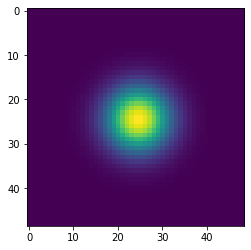

In [5]:
def make_DoG(sigma: int, K: int, shape: tuple[int, int]):
    var = sigma ** 2
    coeff = 1/(2 * np.pi * var)
    
    if not K > 1:
        raise ValueError("K must be greater than 1.")

    def DoG(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        exponent = -((centred_x ** 2 + centred_y ** 2) / (2 * var))
        
        return coeff * np.exp(exponent) - coeff * (K ** -2) * np.exp(exponent * (K ** -2))

    return np.fromfunction(DoG, shape=kernel_shape)


kernel_shape = (49, 49)

DoG = make_DoG(sigma=5, K=10, shape=kernel_shape)
plt.imshow(DoG)
DoG


### Section 2

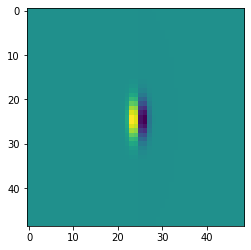

In [50]:
def make_EdgeBarFilter(theta: int,
                       sigma_x: int,
                       sigma_y: int,
                       shape: tuple[int, int],
                       type: types.Literal['edge', 'bar'] = 'edge'):

    def f(x, sigma):
        return ((2 * np.pi * sigma) ** (-0.5)) * np.exp(-(x ** 2) / (2 * (sigma ** 2)))

    def x_prime(x, y):
        return x * np.cos(theta) - y * np.sin(theta)

    def y_prime(x, y):
        return x * np.sin(theta) + y * np.cos(theta)

    def g(x, y):
        return f(x=x_prime(x, y), sigma=sigma_x) * f(x=y_prime(x, y), sigma=sigma_y)

    def first_dir(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        return g(centred_x, centred_y) * ((-y_prime(centred_x, centred_y)) / (sigma_y ** 2))

    def second_dir(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        return g(centred_x, centred_y) * (((y_prime(centred_x, centred_y) ** 2) - (sigma_y ** 2)) / (sigma_y ** 4))

    if type == 'bar':
        return np.fromfunction(second_dir, shape=shape)
        
    return np.fromfunction(first_dir, shape=shape)

In [42]:
sigma_set = np.array([(3, 1), (6, 2), (12, 4)])
theta_set = np.arange(6) * (np.pi/6)
type_set = ['edge', 'bar']
kernel_shape = (49, 49)

rfs = [make_EdgeBarFilter(theta, sigma[0], sigma[1], kernel_shape, type)
               for theta in theta_set for sigma in sigma_set for type in type_set]

In [43]:
rfs.extend([gaussian, LoG])